In [4]:
"""
This example shows how to perform regression of molecular properties with a
database of the atomic geometry of water clusters with an associated energy, 
using a simple GNN in disjoint mode.
"""

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mendeleev import H, O

# Install matplotlib inside the virtual env
#import pip
#pip.main(["install","matplotlib"])
import matplotlib.pyplot as plt

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.datasets import QM9
from spektral.layers import GCSConv, ECCConv, GlobalSumPool, MessagePassing, GATConv, CrystalConv

from spektral.utils.convolution import normalized_adjacency

In [5]:
################################################################################
# Load data and make graphs
################################################################################
class MyDataset(Dataset):
    """
    A dataset of graphs obtained from the atomic positions of water
    clusters with size between 20 and 237 water molecules, each of them
    associated to an energy value.
    """

    def __init__(self, r2_cutoff, n_dim = 3, **kwargs):

        self.r2_cutoff = r2_cutoff
        self.n_dim = n_dim

        # path of the atomic geometry files
        self.geometry_paths = []
        #data_dir = "../dataset_WaterClusters_big/"
        data_dir = "../dataset_WaterClusters_big/"
        #for N in [20,32,47,76,100,139,190,237]:
            #for temp in [100,150,200]:
                #for MDstep in ["0500.dat","1000.dat","1500.dat","2000.dat"]:
                    #geometry_path = data_dir+"N"+str(N)+"-T"+str(temp)+"/"+str(MDstep)
                    #self.geometry_paths.append(geometry_path)
        for folder in os.listdir(data_dir): 
            dir_name = os.path.join(data_dir,folder)
            for file_name in os.listdir(dir_name):
                geometry_path = os.path.join(dir_name,file_name)
                self.geometry_paths.append(geometry_path)

        self.n_samples = len(self.geometry_paths)

        self.Epm_avrg = 0.0
        self.Epm_dev = 0.0
        self.E_avrg = 0.0
        self.E_dev = 0.0
        self.xmax = 22.0
        self.Emax = 0
        self.Emin = 0

        self.num_node_features = 0
        self.num_edge_features = 0
        self.num_labels = 0
        
        super().__init__(**kwargs)

    def read(self):

        def compute_Eavrg():

            # Compute the average energy per molecule among all the clusters

            Epm_avrg = 0.0
            E_avrg = 0.0
            Emax = 0.0
            Emin = 1E6
            
            for ii in range(self.n_samples):
            
                geom_path = self.geometry_paths[ii]
                gfile = open(geom_path,'r')
                line = gfile.readline()
                n_molecules = int(gfile.readline())
                line = gfile.readline()
                line = gfile.readline()
                line = gfile.readline()
                columns = line.split()
                energy = float(columns[0])
                #energy = float(columns[1])  # electron contribution
                gfile.close()

                Epm_avrg = Epm_avrg + energy / float(n_molecules)
                E_avrg = E_avrg + energy
                if(energy>Emax): Emax = energy
                if(energy<Emin): Emin = energy

            Epm_avrg = Epm_avrg / float(self.n_samples)
            E_avrg = E_avrg / float(self.n_samples)

            self.Epm_avrg = Epm_avrg
            self.E_avrg = E_avrg
            self.Emax = Emax
            self.Emin = Emin

            print("E_avrg: "+str(E_avrg))

        def compute_Edev():

            # Compute standard deviation from Epm_avrg

            Epm_dev = 0.0
            E_dev = 0.0

            for ii in range(self.n_samples):
            
                geom_path = self.geometry_paths[ii]
                gfile = open(geom_path,'r')
                line = gfile.readline()
                n_molecules = int(gfile.readline())
                line = gfile.readline()
                line = gfile.readline()
                line = gfile.readline()
                columns = line.split()
                energy = float(columns[0])
                #energy = float(columns[1]) # electron contribution
                gfile.close()

                Epm_dev = Epm_dev + ( energy / float(n_molecules) - self.Epm_avrg )**2
                E_dev = E_dev + ( energy - self.E_avrg )**2

            Epm_dev = np.sqrt( Epm_dev / float(self.n_samples) )
            E_dev = np.sqrt( E_dev / float(self.n_samples) )

            self.Epm_dev = Epm_dev
            self.E_dev = E_dev

            print("E_dev: "+str(E_dev))
            
        def make_graph(isample):

            # Process the header of the geometry file
            geom_path = self.geometry_paths[isample]
            gfile = open(geom_path,'r')
            line = gfile.readline()
            n_molecules = int(gfile.readline())
            line = gfile.readline()
            line = gfile.readline()
            line = gfile.readline()
            columns = line.split()
            energy = float(columns[0])
            #energy = float(columns[1]) # electron contribution
            line = gfile.readline()
            line = gfile.readline()            

            # Node features (atom type and position [x,y,z])            
            n_nodes = 3*n_molecules
            #num_node_features = 1 + self.n_dim
            num_physical_features = 4
            #num_abstract_features = 6
            num_abstract_features = 0
            num_node_features = num_physical_features + num_abstract_features
            self.num_node_features = num_node_features
            x = np.zeros((n_nodes, num_node_features))
            pos = np.zeros((n_nodes, 3))
            for inode in range(n_nodes):
                line = gfile.readline()
                columns = line.split()
                if (inode%3==0):
                    #x[inode,0] = 1.0    # oxygen atom
                    #x[inode,0] = O.atomic_number/O.atomic_number    # oxygen atom
                    x[inode,0] = O.atomic_number
                    #x[inode,1] = O.atomic_radius
                    #x[inode,2] = O.covalent_radius
                    #x[inode,3] = O.vdw_radius
                    #x[inode,4] = O.dipole_polarizability
                    #x[inode,5] = O.electron_affinity
                    #x[inode,6] = O.en_pauling
                    #for l in range(3):
                    #    w = O.atomic_number/O.atomic_number*np.pi/float(l+1)
                    #    x[inode,1+l] = np.sin(w)
                    
                else:
                    #x[inode,0] = 0.0    # hydrogen atom
                    #x[inode,0] = H.atomic_number/O.atomic_number    # hydrogen atom
                    x[inode,0] = H.atomic_number
                    #x[inode,1] = H.atomic_radius
                    #x[inode,2] = H.covalent_radius
                    #x[inode,3] = H.vdw_radius
                    #x[inode,4] = H.dipole_polarizability
                    #x[inode,5] = H.electron_affinity
                    #x[inode,6] = H.en_pauling
                    #for l in range(3):
                    #    w = H.atomic_number/O.atomic_number*np.pi/float(l+1)
                    #    x[inode,1+l] = np.sin(w)
                pos[inode,0:] = columns[1:]
                x[inode,1:] = pos[inode,0:]
                #x[inode,1:] = pos[inode,0:]/float(self.xmax)
                #x[inode,7:] = pos[inode,0:]/float(self.xmax)
                #x[inode,1:] = np.random.random(num_abstract_features)
            gfile.close()                

            # Binary Adjacency matrix (two nodes/atoms are connected if rij2 < r2_cutoff)
            a = np.zeros((n_nodes,n_nodes))
            n_edges = 0
            for iatom in range(3*n_molecules):
                for jatom in range(iatom+1,3*n_molecules):
                    rij = pos[iatom,0:] - pos[jatom,0:]
                    r2 = np.dot(rij,rij)
                    if (r2 <= self.r2_cutoff):
                        #print(iatom,jatom,r2)                        
                        #a[iatom,jatom] = np.sqrt(r2)
                        a[iatom,jatom] = 1
                        n_edges = n_edges + 1            
            a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
            a = sp.csr_matrix(a)
            a = normalized_adjacency(a, symmetric=True)

            """ # Edge features (type of bonding: O-O, H-O, H-H)
            n_edges = n_edges*2
            num_abstract_features = 0
            num_edge_features = 1 + num_abstract_features
            self.num_edge_features = num_edge_features
            e = np.zeros((n_edges,num_edge_features))
            id_edge = 0
            for iatom in range(3*n_molecules):
                for jatom in range(3*n_molecules):
                    if(iatom!=jatom):
                        rij = pos[iatom,0:] - pos[jatom,0:]
                        r2 = np.dot(rij,rij)
                        if (r2 <= self.r2_cutoff):
                            #print(iatom,jatom,r2)                        
                            e[id_edge,0] = np.sqrt(r2)
                            #e[id_edge,1:] = np.random.random(num_abstract_features)
                            id_edge = id_edge + 1 """
            
            # Labels
            num_labels = 1
            self.num_labels = num_labels
            y = np.zeros(num_labels,)
            y[0,] = energy
            #y[0,] = ( energy / float(n_molecules) - self.Epm_avrg ) / self.Epm_avrg
            #y[0,] = ( energy / float(n_molecules) - self.Epm_avrg ) / self.Epm_dev
            #y[0,] = ( energy - self.E_avrg ) / self.E_dev
            #y[0,] = energy - self.E_avrg
            #y[0,] = ( energy - self.E_avrg ) / self.E_dev * 100
            #y[0,] = energy * 100
            
            # Put energies into [0,1]
            #ca = 1.0/(self.Emax-self.Emin)
            #cb = 1.0 - ca * self.Emax
            #y[0,] = ca*energy + cb

            # Put energies into [-1,1]
            #ca = 2.0/(self.Emax-self.Emin)
            #cb = 1.0 - ca * self.Emax
            #y[0,] = ca*energy + cb

            print(str(geom_path)+"    Energy "+str(y[0,]))
            
            return Graph(x=x, a=a, y=y)
            #return Graph(x=x, a=a, e=e, y=y)

        # Compute average of the energy per molecule
        compute_Eavrg()
        compute_Edev()
        # We must return a list of Graph objects
        return [make_graph(isample) for isample in range(self.n_samples)]        

# Generate dataset from atomic geometry files
#d2_cutoff = 20.0
d_cutoff = 6.0
d2_cutoff = d_cutoff * d_cutoff
dataset = MyDataset( d2_cutoff )


E_avrg: -1.678857124507812
E_dev: 1.2688447356520496
../dataset_WaterClusters_big/N20-T150/0350.dat    Energy -0.24305615
../dataset_WaterClusters_big/N20-T150/1700.dat    Energy -0.25697191
../dataset_WaterClusters_big/N20-T150/0100.dat    Energy -0.2451
../dataset_WaterClusters_big/N20-T150/1550.dat    Energy -0.25697741
../dataset_WaterClusters_big/N20-T150/1850.dat    Energy -0.2676109
../dataset_WaterClusters_big/N20-T150/1100.dat    Energy -0.24883782
../dataset_WaterClusters_big/N20-T150/0450.dat    Energy -0.25257631
../dataset_WaterClusters_big/N20-T150/0500.dat    Energy -0.25955347
../dataset_WaterClusters_big/N20-T150/1350.dat    Energy -0.24205364
../dataset_WaterClusters_big/N20-T150/0850.dat    Energy -0.26418391
../dataset_WaterClusters_big/N20-T150/1900.dat    Energy -0.25505501
../dataset_WaterClusters_big/N20-T150/1650.dat    Energy -0.25008463
../dataset_WaterClusters_big/N20-T150/0250.dat    Energy -0.25938082
../dataset_WaterClusters_big/N20-T150/0950.dat    Energ

In [6]:
################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
#learning_rate = 1e-4  # Learning rate
#epochs = 200  # Number of training epochs
#epochs = 400  # Number of training epochs
epochs = 150  # Number of training epochs
batch_size = 4  # Batch size

initial_learning_rate = 1e-3
#learning_rate = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=initial_learning_rate, decay_steps=epochs/10, decay_rate=0.8)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,
#                decay_steps=10, decay_rate=0.98)
                decay_steps=epochs/5, decay_rate=0.99)

"""
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_initial,
    decay_steps=epochs,
    decay_rate=0.98)
"""

# Parameters
F = dataset.num_node_features  # Dimension of node features
S = dataset.num_edge_features  # Dimension of edge features
n_out = dataset.num_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.8 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
#loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size)
# we set epochs=epochs within loader_te to check loss on test set
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=epochs+1)

In [7]:
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        #self.conv1 = ECCConv(32, activation="relu")
        #self.conv2 = ECCConv(32, activation="relu")
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        #self.conv1 = GCSConv(64, activation="tanh")
        #self.conv2 = GCSConv(64, activation="tanh")
        #self.conv3 = GCSConv(64, activation="tanh")
        #self.conv1 = CrystalConv(aggregate="sum",activation="sigmoid")
        #self.conv2 = CrystalConv(aggregate="sum",activation="sigmoid")
        #self.conv1 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        #self.conv2 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        #self.conv1 = GATConv(16,attn_heads=8,dropout_rate=0)
        #self.conv2 = GATConv(16,attn_heads=8,dropout_rate=0)
        #self.conv3 = GATConv(16,attn_heads=8,dropout_rate=0)
        self.global_pool = GlobalSumPool()
        self.dense1 = Dense(128,activation="relu")
        self.dense2 = Dense(128,activation="relu")
        #self.dense1 = Dense(128)
        #self.dense2 = Dense(128)
        #self.dense3 = Dense(128)
        #self.dense = Dense(n_out,activation="sigmoid")
        self.dense = Dense(n_out)

    def call(self, inputs):
        #x, a, e, i = inputs
        #x = self.conv1([x, a, e])
        #x = self.conv2([x, a, e])
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        #x = self.conv3([x, a])
        #x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.dense2(output)
        #output = self.dense3(output)
        output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
#loss_fn = MeanSquaredError()
loss_fn = MeanAbsoluteError()
#loss_fn = MeanAbsolutePercentageError()

2023-01-27 14:32:54.606768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:32:54.659515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-27 14:32:54.659547: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-27 14:32:54.660394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

/home/alfonso/Work/UGR/Calculations/WaterClusters_GNNs/GNNs_WaterClusters_venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/home/alfonso/Work/UGR/Calculations/WaterClusters_GNNs/GNNs_WaterClusters_venv/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1 Loss: 51.44526672363281
2 Loss: 24.053077697753906
3 Loss: 12.773845672607422
4 Loss: 6.7112650871276855
5 Loss: 5.257126808166504
6 Loss: 3.7790744304656982
7 Loss: 2.8353166580200195
8 Loss: 2.0150935649871826
9 Loss: 1.438720941543579
10 Loss: 2.5718789100646973
11 Loss: 1.3025285005569458
12 Loss: 1.4746063947677612
13 Loss: 1.2759218215942383
14 Loss: 0.9939902424812317
15 Loss: 0.9137386083602905
16 Loss: 0.8311832547187805
17 Loss: 0.4977540969848633
18 Loss: 0.7692853808403015
19 Loss: 0.47480103373527527
20 Loss: 0.5476129055023193
21 Loss: 0.4459279775619507
22 Loss: 0.4962233006954193
23 Loss: 0.3361508548259735
24 Loss: 0.30559051036834717
25 Loss: 0.44989368319511414
26 Loss: 0.25424957275390625
27 Loss: 0.21966147422790527
28 Loss: 0.2438422590494156
29 Loss: 0.32346275448799133
30 Loss: 0.20127731561660767
31 Loss: 0.19589944183826447
32 Loss: 0.17800071835517883
33 Loss: 0.1802344024181366
34 Loss: 0.19125106930732727
35 Loss: 0.1958182007074356
36 Loss: 0.17023099958

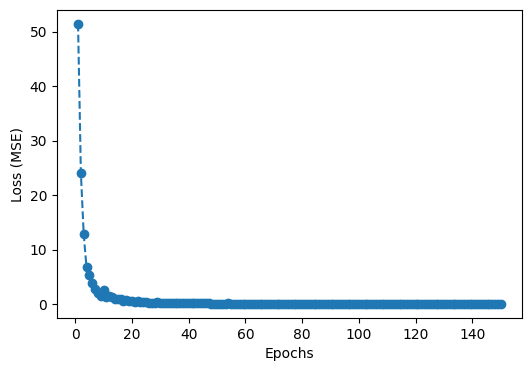

'\n# Plot Loss Function on Test Set\nplt.figure(figsize=(6,4))\nplt.scatter(range(1,epochs+1),loss_test)\nplt.plot(range(1,epochs+1),loss_test,ls="--")\nplt.xlabel("Epochs")\nplt.ylabel("Loss (MSE)")\nplt.show()\n'

In [8]:
################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

outfile = open("loss.dat",'w')
nepoch = 1
step = loss = 0
loss_train = []
#loss_test = []
#loss_te = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print(str(nepoch)+" Loss: {}".format(loss / loader_tr.steps_per_epoch))
        outfile.write(str(nepoch)+" {}".format(loss / loader_tr.steps_per_epoch)+" \n")
        loss_train.append(loss / loader_tr.steps_per_epoch)

        #if(nepoch==epochs): break
        nepoch = nepoch + 1

        # log the loss into wandb
        #wandb.log({"loss": loss / loader_tr.steps_per_epoch})
        
        loss = 0

        """
        # Loss on test set
        batch_te = next(iter(loader_te))
        inputs, target = batch_te
        predictions = model(inputs, training=False)
        #loss_te += loss_fn(target, predictions)
        loss_te = loss_fn(target, predictions)
        #loss_te /= loader_te.steps_per_epoch
        loss_test.append(loss_te)
        #loss_te = 0
        """

outfile.close()

# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

"""
# Plot Loss Function on Test Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_test)
plt.plot(range(1,epochs+1),loss_test,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()
"""


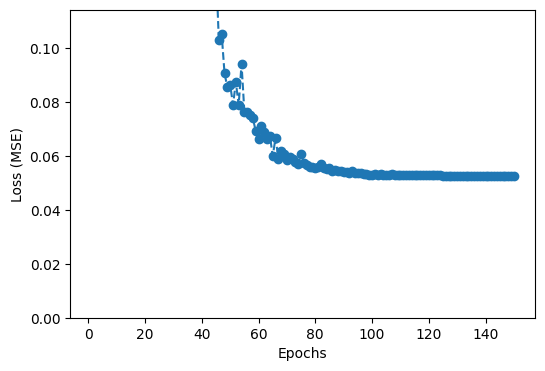

In [9]:
# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
ymedian = np.median(loss_train)
#plt.xlim(0,200)
plt.ylim(0,ymedian*2)
plt.show()

In [10]:
################################################################################
# Evaluate model
################################################################################

# Loss on Test Set. Predicted vs Real energies
print("Testing model")
loss = 0
ypred = []
ytrue = []
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
    ypred.append(predictions)
    ytrue.append(target)
    #break
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))


Testing model
Done. Test loss: 0.0661272257566452


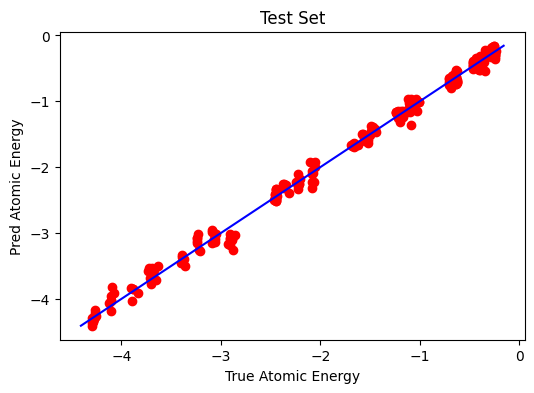

Test MAE: 0.06612723590357081
Test MSE: 0.007735428153654968
Test MAPE: 6.757531890780083


In [11]:
# Plot Predicted vs Real on Test Set

y_pred = np.array(ypred).ravel()
y_true = np.array(ytrue).ravel()

# Convert to original units
#y_pred = np.array(ypred).ravel()#/100
#y_true = np.array(ytrue).ravel()#/100

#E_avrg = -0.025591339035879856
#E_dev = 2.0321151163332116
#y_pred = np.array(ypred).ravel()*E_dev + E_avrg
#y_true = np.array(ytrue).ravel()*E_dev + E_avrg

plt.figure(figsize=(6,4))
plt.scatter(y_true,y_pred,label = "GNN model",color="red")
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.plot(np.linspace(-0.2,0.1,50),np.linspace(-0.2,0.1,50))
plt.xlabel("True Atomic Energy")
plt.ylabel("Pred Atomic Energy")
#plt.xlim(-5,0)
#plt.ylim(-5,0)
plt.title("Test Set")
plt.show()

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    mape_i = np.zeros(len(ytrue))
    mape_i = np.abs((ypred-ytrue)/ytrue)*100
    mape_i = mape_i[ mape_i < 1e3]

    return np.mean(mape_i)

# Compute metrics (MAPE, MAE, MSE)
print("Test MAE:", mean_absolute_error(y_true,y_pred))
print("Test MSE:", mean_squared_error(y_true,y_pred))
print("Test MAPE:", mape(y_true,y_pred))

